# Introduction to `fsic`

This notebook will introduce you to  `fsic`, a Python package for nonparameteric independence testing. See the [Github page](https://github.com/wittawatj/fsic-test) of `fsic` for more information. 

Make sure that you have `fsic` included in Python's search path. In particular the following import statements should not produce any fatal error.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import theano

from fsic import (data, kernel, util)
from fsic import indtest as it

## Demo: NFSIC Test

NFSIC (Normalized Finite Set Independence Criterion) is an indepedence test proposing a null hypothesis 

$H_0: X \text{ and } Y \text{ are independent }$

against an alternative hypothesis

$H_1: X \text{ and } Y \text{ are dependent }$

where $X \in \mathbb{R}^{d_x}, Y \in \mathbb{R}^{d_y}$ are random variables. For demonstration purpose, let us consider a simple one-dimensional toy problem in which $X,Y$ are known to be dependent i.e., $H_1$ is true. A particular instance of such a problem is the Sinusoid problem.

### Sinusoid problem

In the Sinusoid problem, $X, Y \in [-\pi, \pi]$ and the joint probability density is given by 

$p_{xy}(x, y) \propto 1 + \sin(\omega x)\sin(\omega y)$

where $\omega$ is the frequency of the sinusoid controlling the difficulty of the problem (i.e., the higher the $\omega$, the more difficult to detect the dependence). We will use $\omega=1$. A plot of the sample drawn from this model is shown below.

In this framework, a toy problem is represented by a `PairedSource` object (a source of paired sample). Many toy problems are included in `fsic.data` module. Classes implementing a `PairedSource` have names starting with `PS`. Here, we will construct a `PS2DSinFreq` which implements the Sinusoid problem.

In [2]:
omega = 1
ps = data.PS2DSinFreq(freq=omega)

# There are many more PairedSource implmentations.
#ps = data.PSIndSameGauss(dx, dy)
#ps = data.PS2DUnifRotate(angle=np.pi/4)
#ps = data.PSUnifRotateNoise(angle=np.pi/3, noise_dim=2)

In [3]:
# Significance level of the test
alpha = 0.01

# Number of paired samples to draw
n = 1000

# Random seed
seed = 1

In [4]:
# Draw n paired samples from the PairedSource with the random seed
pdata = ps.sample(n, seed=seed)

The drawn sample from a `PairedSource` is represented as an object of `PairedData` class. A `PairedData` object is just an encapsulation of the paired sample $(X, Y)$. The `PairedData` object will be fed to a testing algorithm to conduct the independence test.

In practice, we have acceess to only data matrices X, an $(n \times d_x)$ matrix, and Y, an $(n \times d_y)$ matrix. We can also directly construct a `PairedData` with 

    pdata = data.PairedData(X, Y)
    
Here, we sample it from a `PairedSource`.


Text(0, 0.5, 'y')

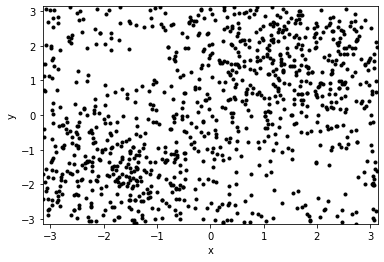

In [5]:
# Let's plot the data.
X, Y = pdata.xy()
plt.plot(X, Y, 'k.')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.xlabel('x')
plt.ylabel('y')

Now that we have `pdata`, let us randomly split it into two disjoint halves: `tr` and `te`. The training set `tr` will be used for parameter optimization. The testing set `te` will be used for the actual independence test. `tr` and `tr` are of type `PairedData`.

In [6]:
tr, te = pdata.split_tr_te(tr_proportion=0.5, seed=seed+1)

Let us optimize the parameters of NFSIC on `tr`. The optimization relies on `theano` to compute the gradient.

In [7]:
# J is the number of test locations
J = 1

# There are many options for the optimization. 
# Almost all of them have default values. 
# Here, we will list a few to give you a sense of what you can control.
op = {
    'n_test_locs': J,  # number of test locations
    'max_iter': 200,   # maximum number of gradient ascent iterations
    'V_step': 1,       # Step size for the test locations of X
    'W_step': 1,       # Step size for the test locations of Y
    'gwidthx_step': 1, # Step size for the Gaussian width of X
    'gwidthy_step': 1, # Step size for the Gaussian width of Y
    'tol_fun': 1e-4,   # Stop if the objective function does not increase more than this
    'seed': seed + 7   # random seed
}

# Do the optimization with the options in op.
op_V, op_W, op_gwx, op_gwy, info = it.GaussNFSIC.optimize_locs_widths(tr, alpha, **op)

The optimization procedure returns back 

1. `op_V`: optimized test locations (features) for $X$. A $J \times d_x$ numpy array.
2. `op_W`: optimized test locations for $Y$. A $J \times d_y$ numpy array.
3. `op_gwx`: optimized Gaussian width (for Gaussian kernels) for $X$. A floating point number.
4. `op_gwy`: optimized Gaussian width (for Gaussian kernels) for $Y$. A floating point number.
5. `info`: information gathered during the optimization i.e., variable trajectories. A dictionary.

Let us use these values to construct an NFSIC test. An NFSIC test using Gaussian kernels is implemented in `fsic.indtest.GaussNFSIC`. This is the same as using Gaussian kernels with the generic implementation `fsic.indtest.NFSIC`.

In [8]:
nfsic_opt = it.GaussNFSIC(op_gwx, op_gwy, op_V, op_W, alpha)

# This is the same as:
# k = kernel.KGauss(op_gwx)
# l = kernel.KGauss(op_gwy)
# nfsic_opt = it.NFSIC(k, l, op_V, op_W, alpha)

Perform the independence test on the testing data `te`.

In [9]:
# return a dictionary of testing results
nfsic_opt.perform_test(te)

{'alpha': 0.01,
 'pvalue': 1.1097871852275815e-20,
 'test_stat': 86.95571186849844,
 'h0_rejected': True,
 'time_secs': 0.0016262531280517578}

It can be seen that the test correctly rejects $H_0$ with a very small p-value.

### Learned test location(s)

Let us check the optimized test locations.

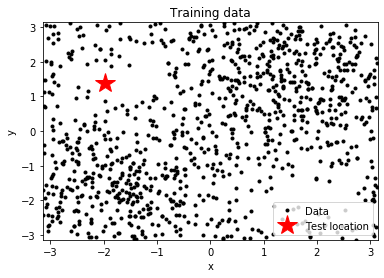

In [10]:
# Let's plot the locations on top of the data
xtr, ytr = tr.xy()
plt.plot(X, Y, 'k.', label='Data')
plt.plot(op_V, op_W, 'r*', label='Test location', markersize=20)
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.title('Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(numpoints=1)

We expect the learned location(s) to be in the region where $p(x, y)$ differs most from $p(x)p(y)$.

##### Exercise 
Go back to where we define the `PairedSource`, and change `omega` to 0. This makes $(X, Y) \sim U([-\pi, \pi]^2)$. In this case, $X$ and $Y$ are independent i.e., $H_0$ is true. Run the whole procedure again and verify that the test will not reject $H_0$. (Technically, the probability of rejecting is about $\alpha$.)